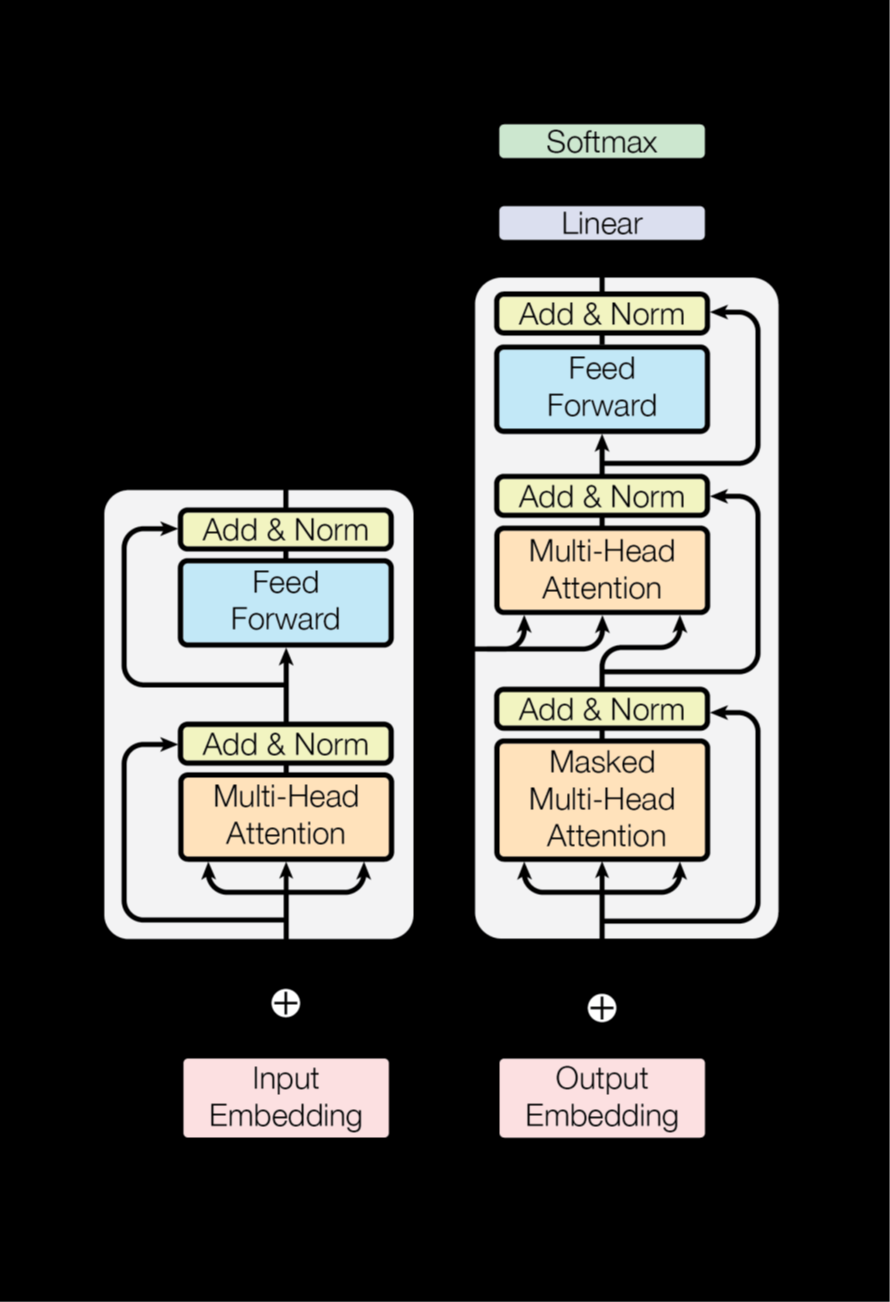

In [57]:
!pip install -q datasets

In [58]:
!pip install -q sacrebleu

In [59]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import sacrebleu
import matplotlib.pyplot as plt
from typing import Tuple
import pandas as pd
import numpy as np
from datasets import load_dataset
import math
from tqdm import tqdm
from transformers import MarianTokenizer
from nltk.translate.bleu_score import sentence_bleu
import warnings
warnings.filterwarnings('ignore')

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

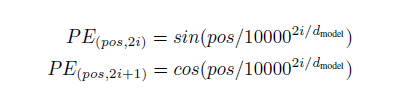

In [61]:
class PositionEncoding(torch.nn.Module):
  """Positional Encoding for Transformer model.
  Args:
      d_model (int): Embedding dimension.
      max_len (int): Maximum length of input sequences (default 128)."""

  def __init__(self, d_model: int, max_len: int=128, device=device) -> None:
    super().__init__()
    pe = torch.zeros(max_len, d_model).to(device)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1).to(device)
    div_term = 10000 ** (torch.arange(0, d_model, 2).float() / d_model).to(device)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)  # Add batch dimension
    self.register_buffer('pe', pe)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward pass to add positional encoding to input embeddings.
    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, max_len, d_model).

    Returns:
        x (torch.Tensor): Output tensor with position encoding added to it of shape (batch_size, max_len, d_model)."""
    x = x.to(device)
    x = x + self.pe[:x.size(1), :]  # Apply positional encoding
    return x

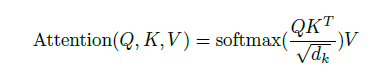

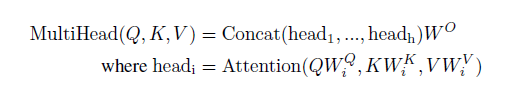

In [62]:
class MultiHeadSelfAttention(nn.Module):
  """Multi-head attention module.
  Args:
      d_model (int): Embedding dimension.
      num_heads (int): Number of attention heads."""

  def __init__(self, d_model: int, num_heads: int) -> None:
    super().__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    self.d_k = d_model // num_heads
    self.W_q = nn.Linear(in_features=d_model, out_features=d_model)
    self.W_k = nn.Linear(in_features=d_model, out_features=d_model)
    self.W_v = nn.Linear(in_features=d_model, out_features=d_model)
    self.W_o = nn.Linear(in_features=d_model, out_features=d_model)

  def scaled_dot_product_attention(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None) -> Tuple[torch.Tensor, torch.Tensor]:
    """Calculate scaled dot product attention.
    Args:
        query (torch.Tensor): Query tensor of shape (batch_size, num_heads, max_len, d_k).
        key (torch.Tensor): Key tensor of shape (batch_size, num_heads, max_len, d_k).
        value (torch.Tensor): Value tensor of shape (batch_size, num_heads, max_len, d_k).
        mask (torch.Tensor, optional): Optional mask tensor.

    Returns:
        Tuple:
            attn_output (torch.Tensor): Output of the attention layer.
            attn_weights (torch.Tensor): Attention weights."""
    # print(f"SDPA input shapes: {query.shape, key.shape, value.shape}")
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)  # Scaled dot product
    if mask is not None:
      # print(f"Original mask shape: {mask.shape}")  # Print before unsqueeze
      mask = mask.unsqueeze(1)  # Reshape to (batch_size, 1, seq_len, seq_len)
      # print(f"Mask shape after unsqueeze: {mask.shape}")  # Print after unsqueeze
      # Check for expected dimensions before repeat
      if len(mask.shape) == 4:
          mask = mask.repeat(1, self.num_heads, 1, 1)
          # print(f"Mask shape after repeat: {mask.shape}")  # Print after repeat
          scores = scores.masked_fill(mask == 0, -1e9)
      # else:
          # print(f"Warning: Skipping repeat and mask_fill - mask shape: {mask.shape}")
    attn_weights = torch.softmax(scores, dim=-1)  # Softmax
    attn_output = torch.matmul(attn_weights, value)  # Weighted sum
    return attn_output, attn_weights

  def forward(self, x: torch.Tensor, mask=None) -> Tuple[torch.Tensor, torch.Tensor]:
    """Forward pass for Multi-head Attention.
    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, max-len, d_model).
        mask (torch.Tensor, optional): Mask of input tensor (default None).

    Returns:
        Tuple:
            output (torch.Tensor): Output tensor of shape (batch_size, max_len, d_model).
            attn_weights (torch.Tensor): Attention weights tensor of shape (batch_size, num_heads, max_len, max_len)."""

    # print(f"Multihead Attention input shape: {x.shape}")
    batch_size = x.size(0)
    Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
    K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
    V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
    attn_output, attn_weights = self.scaled_dot_product_attention(Q, K, V, mask)
    attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
    output = self.W_o(attn_output)
    # print(f"Multihead Attention output shapes: {output.shape, attn_weights.shape}")
    return output, attn_weights

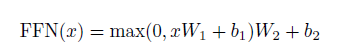

In [63]:
class FeedForwardNetwork(nn.Module):
  """Feed-forward network module.
  Args:
      d_model (int): Embedding dimension (default 512).
      d_ff (int): Feed forward network dimension (default 2048).
      dropout (float): dropout value (default 0.1)."""

  def __init__(self, d_model: int=512, d_ff: int=2048, dropout: float=0.1) -> None:
    super().__init__()
    self.ffn_block = nn.Sequential(
      nn.Linear(in_features=d_model, out_features=d_ff),
      nn.ReLU(),
      nn.Dropout(p=dropout),
      nn.Linear(in_features=d_ff, out_features=d_model),
    )

  def forward(self, x: torch.Tensor):
    """Forward pass for feed-forward network layer.
    Args:
        x (torch.Tensor): Tensor of shape (batch_size, max_len, d_model).

    Returns:
        x (torch.Tensor): Output tensor of shape (batch_size, max_len, d_model)."""

    # print(f"Feedforward network input shape: {x.shape}")
    x = self.ffn_block(x)
    # print(f"Feedforward network output shape: {x.shape}")
    return x

In [64]:
class EncoderLayer(nn.Module):
  """A single Encoder layer
  Args:
      d_model (int): Embedding dimension.
      num_heads (int): Number of attention heads.
      d_ff (int): Feed foward network dimension.
      dropout (float): Dropout value (default 0.1)."""

  def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout=0.1) -> None:
    super().__init__()
    self.mha = MultiHeadSelfAttention(d_model, num_heads)
    self.layernorm1 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(p=dropout)
    self.ffn = FeedForwardNetwork(d_model, d_ff, dropout)
    self.layernorm2 = nn.LayerNorm(d_model)
    self.dropout2 = nn.Dropout(p=dropout)

  def forward(self, x: torch.Tensor, mask: torch.Tensor=None) -> torch.Tensor:
    """Forward pass for the encoder layer.
    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, max_len, d_model).
        mask (torch.Tensor, optional): Optional mask of input tensor (default None).

    Returns:
        x (torch.Tensor): Output tensor of shape (batch_size, max_len, d_model)."""
    # print(f"Encoder layer input shape: {x.shape}")
    attn_output, _ = self.mha(x, mask) # Multi-head attention
    x = self.layernorm1(x + self.dropout1(attn_output)) # Add and norm
    ffn_output = self.ffn(x) # Feed forward network
    x = self.layernorm2(x + self.dropout2(ffn_output)) # Add and norm
    # print(f"Encoder layer output shape: {x.shape}")
    return x

In [65]:
class DecoderLayer(nn.Module):
  """A single Decoder layer.
  Args:
      d_model (int): Embedding dimension.
      num_heads (int): Number of attention heads.
      d_ff (int): Feed forward network dimension.
      dropout (float): Dropout value (default 0.1)"""

  def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float=0.1) -> None:
    super().__init__()
    self.self_attn = MultiHeadSelfAttention(d_model, num_heads) # Masked MHA
    self.cross_attn = MultiHeadSelfAttention(d_model, num_heads) # Cross-attention
    self.layernorm1 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(p=dropout)
    self.layernorm2 = nn.LayerNorm(d_model)
    self.dropout2 = nn.Dropout(p=dropout)
    self.ffn = FeedForwardNetwork(d_model, d_ff, dropout)
    self.layernorm3 = nn.LayerNorm(d_model)
    self.dropout3 = nn.Dropout(p=dropout)

  def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, tgt_mask: torch.Tensor=None, src_mask: torch.Tensor=None) -> torch.Tensor:
    """Forward pass for decoder layer.
    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, max_len, d_model).
        encoder_output (torch.Tensor): Output tensor from the encoder, shape (batch_size, max_len, d_model).
        tgt_mask (torch.Tensor, optional): Mask tensor for masked multi-head attention (default None).
        src_mask (torch.Tensor, optional): Mask tensor for padding (default None).

    Returns:
        x (torch.Tensor): Output tensor of shape (batch_size, max_len, d_model)."""
    # print(f"Decoder Layer input shapes: {x.shape, encoder_output.shape}")
    attn_output, _ = self.self_attn(x, tgt_mask) # masked multi-head attention
    x = self.layernorm1(x + self.dropout1(attn_output)) # add and norm

    attn_output, _ = self.cross_attn(x, src_mask) # multi-head attention
    x = self.layernorm2(x + self.dropout2(attn_output)) # add and norm

    ffn_output = self.ffn(x) # feed forward network
    x = self.layernorm3(x + self.dropout3(ffn_output)) # add and norm
    # print(f"Decoder layer output shape: {x.shape}")
    return x

In [66]:
class Encoder(nn.Module):
  """Encoder block.
  Args:
      d_model (int): Embedding dimension.
      d_ff (int): Feed forward network dimension.
      num_heads (int): Number of attention heads.
      max_len (int): Max length of input sequence. (default 128).
      dropout (float): Dropout value (default 0.1).
      num_layers (int): Number of encoder layers (default 6)."""

  def __init__(self, d_model: int, d_ff: int, num_heads: int, max_len: int=128, dropout: float=0.1, num_layers: int=6) -> None:
    super().__init__()
    self.d_model = d_model
    self.position_encoding = PositionEncoding(d_model, max_len)
    self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x: torch.Tensor, mask: torch.Tensor=None) -> torch.Tensor:
    """Forward pass for the encoder block.
    Args:
        x (torch.Tensor): Input tensor of shape (d_model, max_len).
        mask (torch.Tensor, optional): Optional mask for input tensor.

    Returns:
        x (torch.Tensor): Output tensor of shape (batch_size, d_model, max_len)."""
    # print(f"Encoder input shape: {x.shape}")
    x = self.position_encoding(x * math.sqrt(self.d_model))
    x = self.dropout(x)
    for layer in self.layers:
      x = layer(x, mask)
    # print(f"Encoder output shape: {x.shape}")
    return x

In [67]:
class Decoder(nn.Module):
  """Decoder block.
  Args:
      d_model (int): Embedding dimension.
      d_ff (int): Feed forward network dimension.
      num_heads (int): Number of attention heads.
      max_len (int): Max length of input sequence (default 128).
      dropout (float): Dropout value (default 0.1).
      num_layers (int): Number of decoder layers (default 6)."""

  def __init__(self, d_model: int, d_ff: int, num_heads: int, max_len: int=128, dropout: float=0.1, num_layers: int=6, vocab_size=128) -> None:
    super().__init__()
    self.d_model = d_model
    self.position_encoding = PositionEncoding(d_model, max_len)
    self.embedding = nn.Embedding(vocab_size, d_model)  # Add embedding layer
    self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, tgt_mask: torch.Tensor=None, src_mask: torch.Tensor=None) -> torch.Tensor:
    """Forward pass for the decoder block.
    Args:
        x (torch.Tensor): Input tensor of shape (d_model, max_len).
        encoder_output (torch.Tensor): Output tensor from the encoder block, shape (batch_size, d_model, max_len).
        mask (torch.Tensor, optional): Optional mask of input tensor.
        padding_mask (torch.Tensor, optional): Optional padding mask.

    Returns:
        x (torch.Tensor): Output tensor of shape (batch_size, max_len, d_model)."""
    src_mask = src_mask.to(device)
    tgt_mask = tgt_mask.to(device)

    # print(f"Decoder input shape: {x.shape}")
    x = x.to(device)
    x = self.embedding(x)
    x = self.position_encoding(x * math.sqrt(self.d_model))
    x = self.dropout(x)
    for layer in self.layers:
      x = layer(x, encoder_output, tgt_mask, src_mask)
    # print(f"Decoder output shape: {x.shape}")
    return x

In [68]:
class Transformer(nn.Module):
  """Transformer block.
  Args:
      d_model (int): Embedding dimension.
      d_ff (int): Feed forward network dimension.
      target_size (int): Target size for the output sequence.
      max_len (int): Max length of the input sequence (default 128).
      dropout (float): Dropout value (default 0.1).
      num_layers (int): Number of encoder and decoder layers (default 6)."""

  def __init__(self, d_model: int, d_ff: int, num_heads: int, target_size: int, max_len: int=128, dropout: float=0.1, num_layers: int=6) -> None:
    super().__init__()
    self.encoder = Encoder(d_model, d_ff, num_heads, max_len, dropout, num_layers)
    self.decoder = Decoder(d_model, d_ff, num_heads, max_len, dropout, num_layers, target_size)
    self.linear = nn.Linear(in_features=d_model, out_features=target_size)

  def forward(self, encoder_input: torch.Tensor, decoder_input: torch.Tensor, encoder_mask: torch.Tensor=None, decoder_mask: torch.Tensor=None) -> torch.Tensor:
    """Forward pass for the transformer block
    Args:
        encoder_input (torch.Tensor): Input tensor for the encoder, shape (batch_size, max_len, d_model).
        decoder_input (torch.Tensor): Input tensor for the decoder, shape (batch_size, max_len, d_model).
        encoder_mask (torch.Tensor, optional): Optional mask for the encoder input.
        decoder_mask (torch.Tensor, optional): Optional mask for the decoder input.

    Returns:
        x (torch.Tensor): Output from the transformer, shape (batch_size, d_model, max_len)"""
    # print(f"Transformer input shapes: {encoder_input.shape, decoder_input.shape}")
    encoder_output = self.encoder(encoder_input, encoder_mask)
    decoder_output = self.decoder(decoder_input, encoder_output, decoder_mask, encoder_mask)
    output = self.linear(decoder_output)
    # print(f"Transformer output shape: {output.shape}"
    return output

In [69]:
def create_mask(src, tgt, pad_idx):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]
    # Encoder mask (padding mask)
    src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, src_seq_len)
    # Decoder mask (padding mask + look-ahead mask)
    tgt_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, tgt_seq_len)
    seq_mask = generate_square_subsequent_mask(tgt_seq_len).to(src.device)
    # Expand seq_mask to have the same dimensions as tgt_mask before the bitwise operation
    seq_mask = seq_mask.unsqueeze(0).expand(tgt_mask.shape[0], -1, -1)  # Remove one dimension here
    # Convert seq_mask to bool before the bitwise operation
    seq_mask = seq_mask.type(torch.bool)
    return src_mask, seq_mask  # Return the correct masks

# Function to generate a square subsequent mask for the decoder
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [70]:
dataset = load_dataset("wmt14", "de-en")
train_dataset = dataset['train']
test_dataset = dataset['test']
val_dataset = dataset['validation']

ten_percent_train = int(len(train_dataset) * 0.1)

train_dataset = train_dataset.shuffle().select(range(ten_percent_train))

In [71]:
dataset.keys()

dict_keys(['train', 'validation', 'test'])

In [72]:
# Load the MarianMT tokenizer for translation (German to English)
tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-en")
# Custom Dataset class for tokenization
class TranslationDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=128, d_model=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.embedding = nn.Embedding(len(tokenizer), d_model)  # Add embedding layer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['translation']['de']
        labels = self.dataset[idx]['translation']['en']
        model_input = self.tokenizer(text, truncation=True, max_length=self.max_length, padding='max_length', return_tensors='pt')
        with self.tokenizer.as_target_tokenizer():
            labels = self.tokenizer(labels, truncation=True, max_length=self.max_length + 1,  # Add 1 for <start> token
                                      padding='max_length', return_tensors='pt')
            decoder_input_ids = labels['input_ids'][:, :-1]  # Remove last token (usually padding)
        # Embed input and ensure correct dimensions
        # print(f"Input IDs shape before embedding: {model_input['input_ids'].shape}")  # Print input shape
        embeddings = self.embedding(model_input['input_ids'].squeeze())
        # print(f"Embeddings shape after embedding: {embeddings.shape}")  # Print embedding shape
        return {
            'input_ids': embeddings,
            'labels': labels['input_ids'].squeeze()
        }

# Create the tokenized train and test datasets
train_dataset_tokenized = TranslationDataset(train_dataset, tokenizer)
test_dataset_tokenized = TranslationDataset(test_dataset, tokenizer)

# Create DataLoader for batching and shuffling
train_dataloader = DataLoader(train_dataset_tokenized, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset_tokenized, batch_size=32)
# Example: print the first batch
for batch in train_dataloader:
    print(batch.keys())
    break

dict_keys(['input_ids', 'labels'])


In [100]:
class CustomScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, d_model, warmup_steps=400):
      self._step_num = 1
      self.optimizer = optimizer
      self.d_model = d_model
      self.warmup_steps = warmup_steps
      super().__init__(optimizer)

    def get_lr(self):
      arg1 = torch.tensor(self._step_num) ** -0.5
      arg2 = self._step_num * (self.warmup_steps ** -1.5)
      lr = (self.d_model ** -0.5) * min(arg1, arg2)
      self._step_num += 1
      return [lr]

In [91]:
# Training function
def train(model, train_dataloader, optimizer, criterion, scheduler, device, epoch, max_grad_norm=1.0):
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", leave=False)):
        src = batch['input_ids'].to(device)
        tgt = batch['labels'].to(device)
        # Create masks using the new function
        src_mask, tgt_mask = create_mask(src, tgt[:, :-1], tokenizer.pad_token_id)
        tgt_input = tgt[:, :-1]
        tgt_labels = tgt[:, 1:]

        # Forward pass: Get the model output
        output = model(src, tgt_input, src_mask, tgt_mask)  # Pass the new masks

        # Calculate the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_labels.contiguous().view(-1))

        optimizer.zero_grad()

        # Backward pass: Compute gradients
        loss.backward()

        # Gradient clipping (optional but recommended for preventing exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Update model parameters using the optimizer
        optimizer.step()

        scheduler.step(epoch=None)

        # Accumulate the loss for monitoring
        total_loss += loss.item()

        if batch_idx % 200 == 0:  # Print every 200 batches
            print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")

    # Compute average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}")
    return avg_loss

In [92]:
# Evaluation function
def evaluate(model, val_dataloader, criterion, device, tokenizer):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_references = []
    all_candidates = []

    with torch.inference_mode():  # No gradients needed for evaluation
        for batch_idx, batch in enumerate(tqdm(val_dataloader, desc="Evaluating", leave=False)):
            src = batch['input_ids'].to(device)
            tgt = batch['labels'].to(device)
            src_mask = (src != tokenizer.pad_token_id).to(device)
            tgt_input = tgt[:, :-1]
            tgt_labels = tgt[:, 1:]

            # Forward pass
            output = model(src, tgt_input, src_mask[:, None, None, :], src_mask[:, None, None, :])

            # Calculate the loss
            loss = criterion(output.view(-1, output.size(-1)), tgt_labels.contiguous().view(-1))
            total_loss += loss.item()

            predicted_ids = torch.argmax(output, dim=-1)
            predicted_translations = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)
            reference_translations = tokenizer.batch_decode(tgt_labels, skip_special_tokens=True)

            all_references.extend(reference_translations)
            all_candidates.extend(predicted_translations)

    avg_loss = total_loss / len(val_dataloader)
    print(f"Validation Loss: {avg_loss:.4f}")

    bleu_score = 0
    for ref, cand in zip(all_references, all_candidates):
      bleu_score += calculate_bleu_score([ref], cand)

    bleu_score /= len(all_references)
    print(f"BLEU score: {bleu_score:.4f}")

    return avg_loss, bleu_score

In [93]:
def calculate_bleu_score(references, candidate):
  references = [ref.split() for ref in references]
  candidate = candidate.split()
  bleu = sentence_bleu(references, candidate)
  return bleu

In [94]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
learning_rate = 1e-4
num_epochs = 7
max_grad_norm = 1.0  # Gradient clipping

In [101]:
# Initialize model, optimizer, and loss function
model = Transformer(d_model=512, d_ff=2048, num_heads=8, target_size=len(tokenizer), num_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
scheduler = CustomScheduler(optimizer, d_model=512, warmup_steps=400)

In [102]:
train_losses = []
val_losses = []
bleu_scores = []

# Training loop
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_dataloader, optimizer, criterion, scheduler, device, epoch, max_grad_norm)
    train_losses.append(train_loss)
    # Evaluation
    val_loss, bleu_score = evaluate(model, test_dataloader, criterion, device, tokenizer)
    val_losses.append(val_loss)
    bleu_scores.append(bleu_score)

    # Save the best model (based on validation loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"best_transformer_model_epoch_{epoch+1}.pt")

Training Epoch 1:   7%|▋         | 1/15 [00:00<00:07,  1.78it/s]

Batch 0, Loss: 11.0700


Epoch 1, Training Loss: 10.3453


Validation Loss: 9.7699
BLEU score: 0.0000


Training Epoch 2:   7%|▋         | 1/15 [00:00<00:08,  1.68it/s]

Batch 0, Loss: 9.6244


Epoch 2, Training Loss: 9.1248


Validation Loss: 8.8696
BLEU score: 0.0000


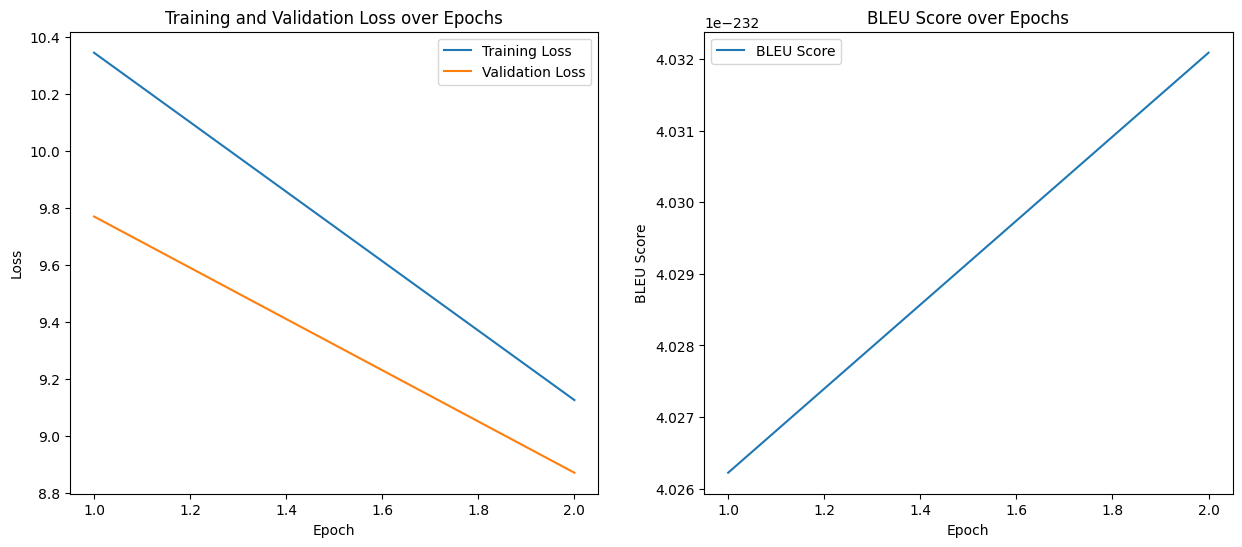

In [103]:
# Plotting the training and validation loss
def plot_loss_graphs(train_losses, val_losses, bleu_scores):
    epochs = range(1, len(train_losses) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(epochs, train_losses, label='Training Loss')
    ax1.plot(epochs, val_losses, label='Validation Loss')
    ax2.plot(epochs, bleu_scores, label='BLEU Score')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('BLEU Score')
    ax1.set_title('Training and Validation Loss over Epochs')
    ax2.set_title('BLEU Score over Epochs')
    ax1.legend()
    ax2.legend()
    plt.show()

# After training, plot the loss graph
plot_loss_graphs(train_losses, val_losses, bleu_scores)